In [520]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns

In [2]:
referrals_big = pd.read_csv('data/referrals_big.csv')

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
referrals_big = referrals_big[referrals_big['entity_from'] == 1.0]

In [5]:
referrals_big.to_csv('data/referrals_big_filtered')

In [329]:
classification_exclusions = ['Radiology', 'Emergency Medicine', 'Pathology', 'Clinical Medical Laboratory', 'Physiological Laboratory','Anesthesiology']

In [331]:
referrals_big_filtered = referrals_big[(~referrals_big['classification_from'].isin(classification_exclusions)) & 
              (~referrals_big['classification_to'].isin(classification_exclusions))]

In [6]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

comm2 = pd.read_csv('data/communities2')

In [7]:
to_comm2 = comm2[comm2['from_npi'].isna()].drop(columns = ['from_npi']).rename(columns={'communityId':'to_communityid'})

In [8]:
from_comm2 = comm2[comm2['to_npi'].isna()].drop(columns = ['to_npi']).rename(columns={'communityId':'from_communityid'})

In [9]:
to_comm2['to_npi']=to_comm2['to_npi'].astype(int)
from_comm2['from_npi']=from_comm2['from_npi'].astype(int)

In [10]:
tax_hop_comm = pd.merge(referrals_big,to_comm2, on = 'to_npi')

In [11]:
tax_hop_comm = pd.merge(tax_hop_comm, from_comm2, on = 'from_npi')

In [12]:
tax_hop_comm['organization_to'] = tax_hop_comm['organization_to'].fillna('none')

In [13]:
tax_hop_comm[tax_hop_comm['organization_to'].str.contains('VANDERBILT')]['to_communityid'].unique()

array([12834,  9794], dtype=int64)

In [14]:
vanderbilt_communities = [12834,  9794]

In [15]:
tax_hop_comm[~tax_hop_comm['from_communityid'].isin(vanderbilt_communities)]['from_npi'].nunique()

19738

In [16]:
tax_hop_comm[tax_hop_comm['from_communityid'].isin(vanderbilt_communities)]['from_npi'].nunique()

3578

19738 doctors outside of vandy communities, 3578 in vandy community

In [24]:
hospital_comms = tax_hop_comm[tax_hop_comm['classification_to'].str.contains('Hospital')]

In [25]:
pd.DataFrame(hospital_comms[~hospital_comms['from_communityid'].isin(vanderbilt_communities)]
             .groupby('organization_to')
             ['patient_count'].sum()).sort_values('patient_count', ascending = False).head(10)

,patient_count
organization_to,
"HCA HEALTH SERVICES OF TENNESSEE, INC.",334284
MAURY REGIONAL HOSPITAL,167597
SAINT THOMAS RUTHERFORD HOSPITAL,84959
none,80607
HTI MEMORIAL HOSPITAL CORPORATION,78942
SUMNER REGIONAL MEDICAL CENTER LLC,58770
HENDERSONVILLE HOSPITAL CORPORATION,53740
VANDERBILT UNIVERSITY MEDICAL CENTER,51909
CENTRAL TENNESSEE HOSPITAL CORPORATION,42097


Largest hospital outside of the vanderbilt community is HCA. Explore the doctors outside of vanderbilt community that still refer to vanderbilt. Could be an interesting insight because they already refer to vanderbilt hospitals. Also look at specializations

In [26]:
conditions = [hospital_comms['organization_to'].str.contains('VANDERBILT'), ~hospital_comms['organization_to'].str.contains('VANDERBILT')]
choices = ['Vanderbilt','Other']

hospital_comms['Vanderbilt?'] = np.select(conditions, choices)

<ipython-input-26-a1528850b05c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_comms['Vanderbilt?'] = np.select(conditions, choices)


This is creating dataframe of npis out of the vanderbilt communities that may still refer to vanderbilt

In [28]:
outside_vandy = pd.DataFrame(hospital_comms[~hospital_comms['from_communityid'].isin(vanderbilt_communities)]
             .groupby(['from_npi','Vanderbilt?'])
             ['patient_count'].sum()).reset_index()

In [29]:
outside_vandy_docs = outside_vandy[outside_vandy['Vanderbilt?'] == 'Vanderbilt'].from_npi.to_list()

In [30]:
recs = outside_vandy[outside_vandy['from_npi'].isin(outside_vandy_docs)].pivot(index = 'from_npi',columns = 'Vanderbilt?', values = 'patient_count')

In [31]:
recs['difference'] = abs(recs['Other'] - recs['Vanderbilt'])

In [32]:
recs = recs.sort_values('difference').dropna()

In [33]:
recs

Vanderbilt?,Other,Vanderbilt,difference
from_npi,,,
1790757755,46,45,1
1114956687,163,164,1
1528046109,22,23,1
1720452360,48,47,1
1245233063,117,119,2
...,...,...,...
1073856696,2155,68,2087
1932465812,2435,118,2317
1942284658,3155,70,3085


In [34]:
recs.to_csv('data/recs.csv')

In [60]:
from_comm2.to_csv('data/from_communities.csv', index = False)

In [59]:
to_comm2.to_csv('data/to_communities.csv', index = False)

In [37]:
tax_hop_comm['from_npi'].nunique()

23316

In [38]:
comm2['communityId'].nunique()

627

In [43]:
hospital_comms['to_communityid'].nunique()

20

In [85]:
hospital_comms['specialization2_from'] = hospital_comms['classification_from'] + '(' + hospital_comms['specialization_from'] + ')'

<ipython-input-85-d01d2c363a3b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_comms['specialization2_from'] = hospital_comms['classification_from'] + '(' + hospital_comms['specialization_from'] + ')'


In [88]:
hospital_comms['specialization2_from'] = hospital_comms['specialization2_from'].fillna(hospital_comms['classification_from'])

<ipython-input-88-aec25e558766>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_comms['specialization2_from'] = hospital_comms['specialization2_from'].fillna(hospital_comms['classification_from'])


In [173]:
hospital_comms[(hospital_comms['organization_to'].str.contains('VANDERBILT'))]['classification_to'].unique()

array(['General Acute Care Hospital', 'Rehabilitation Hospital'],
      dtype=object)

Vanderbilt gets no referrals to its rehabilatation hospital from outside of its community.

In [212]:
doctors_outside = pd.DataFrame(hospital_comms[~hospital_comms['from_communityid'].isin(vanderbilt_communities)]
             .groupby(['city_from','state_from'])
             .agg({'patient_count':'sum',
                   'from_npi':'nunique'})).sort_values('from_npi',ascending = False).rename(columns = {'patient_count':'patient_count_other',
                                                                                                      'from_npi':'doctor_count_other'}).reset_index()

In [213]:
doctors_inside =  pd.DataFrame(hospital_comms[hospital_comms['from_communityid'].isin(vanderbilt_communities)]
             .groupby(['city_from','state_from'])
             .agg({'patient_count':'sum',
                   'from_npi':'nunique'})).sort_values('from_npi',ascending = False).rename(columns = {'patient_count':'patient_count_vandy',
                                                                                                      'from_npi':'doctor_count_vandy'}).reset_index()

In [214]:
doctor_comp = pd.merge(doctors_outside,doctors_inside, on = ['city_from','state_from'])

In [215]:
doctor_comp_prob = doctor_comp[doctor_comp['doctor_count_other'] > doctor_comp['doctor_count_vandy']]

In [216]:
doctor_comp_prob['doc_diff'] = doctor_comp_prob['doctor_count_other'] - doctor_comp_prob['doctor_count_vandy']
doctor_comp_prob['patient_diff'] = doctor_comp_prob['patient_count_other'] - doctor_comp_prob['patient_count_vandy']

<ipython-input-216-25a07ac08550>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doctor_comp_prob['doc_diff'] = doctor_comp_prob['doctor_count_other'] - doctor_comp_prob['doctor_count_vandy']
<ipython-input-216-25a07ac08550>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doctor_comp_prob['patient_diff'] = doctor_comp_prob['patient_count_other'] - doctor_comp_prob['patient_count_vandy']


In [219]:
doctor_comp_prob[doctor_comp_prob['state_from'] == 'TN'].sort_values(['patient_diff','doc_diff'], ascending = False).head(5)

,city_from,state_from,patient_count_other,doctor_count_other,patient_count_vandy,doctor_count_vandy,doc_diff,patient_diff
2,COLUMBIA,TN,111557,215,353,5,210,111204
1,MURFREESBORO,TN,84454,262,5274,29,233,79180
4,HENDERSONVILLE,TN,40140,90,3586,16,74,36554
5,GALLATIN,TN,35528,87,632,3,84,34896
3,HERMITAGE,TN,33876,96,3121,16,80,30755


Murfreesboro, Columbia, Gallatin, Hermitage, and Hendersonville have the highest difference in number of patients from inside the vanderbilt community and number of patients from outside of the Vanderbilt community. These places all have more doctors outside the vanderbilt community than in the vanderbilt community.


In [225]:
referrals_big.shape

(120612, 31)

Identify the major communities in the Nashville CBSA, where major will probably be determined by patient count.

In [362]:
major_hospital_comms = pd.DataFrame(hospital_comms_filtered.groupby('to_communityid')['patient_count'].sum()).sort_values('patient_count', ascending = False)

In [363]:
major_hospital_comms['total'] = sum(major_hospital_comms.patient_count)

In [364]:
major_hospital_comms['patient_count'] = major_hospital_comms['patient_count'].astype('float')
major_hospital_comms['total'] = major_hospital_comms['total'].astype('float')

In [365]:
major_hospital_comms['mkt_share'] = major_hospital_comms['patient_count'] * 100/ major_hospital_comms['total'].astype('float')

In [366]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
major_hospital_comms.head(7)

,patient_count,total,mkt_share
to_communityid,,,
12834,334696.00,1216724.00,27.51
16944,333486.00,1216724.00,27.41
9794,260208.00,1216724.00,21.39
28767,137023.00,1216724.00,11.26
20624,57570.00,1216724.00,4.73
12640,52512.00,1216724.00,4.32
8163,22568.00,1216724.00,1.85


7 communities contain at least 1 percent of total patients, two being communities that vanderbilt belongs to.

for each community where Vanderbilt is already present, we want the optimize the number of patients coming from legit specializations and recruitable providers

Vanderbilt  exclusively makes up all of community 12834, but is the third largest hospital in community 9794, behind st. thomas west and Williamson county hospital district.

In [367]:
major_hospital_comms = major_hospital_comms.reset_index()

In [368]:
top5_nonvandy_comms = major_hospital_comms[~major_hospital_comms['to_communityid'].isin(vanderbilt_communities)].head(5).to_communityid.to_list()

In [369]:
top5_nonvandy_comms

[16944, 28767, 20624, 12640, 8163]

In [373]:
city_comm = pd.DataFrame(hospital_comms_filtered[hospital_comms_filtered['from_communityid'].isin(top5_nonvandy_comms)].groupby(['city_from','from_communityid'])['patient_count'].sum()).reset_index().sort_values(['from_communityid', 'patient_count'], ascending = False)

Exclude:
- Radiology
- Emergency
- Pathology
- Laboratory
- Anesthesiology

what communities should vanderbilt try to insert itself into? 

In [374]:
city_comm.groupby('from_communityid').head(1)

,city_from,from_communityid,patient_count
54,COLUMBIA,28767,64150
220,MURFREESBORO,20624,40846
225,NASHVILLE,16944,161010
106,GALLATIN,12640,24010
71,DICKSON,8163,15906


16944 are centered in Nashville

In [308]:
nashville_non_vandy = [16944]

In [375]:
pd.DataFrame(hospital_comms[hospital_comms['from_communityid'].isin(nashville_non_vandy)].groupby(['city_from'])['patient_count'].sum()).sort_values('patient_count',ascending=False)

,patient_count
city_from,
NASHVILLE,368644
HERMITAGE,28237
HENDERSONVILLE,22403
DICKSON,18920
CLARKSVILLE,13901
...,...
MC EWEN,36
DECATURVILLE,31
COUNCE,31


In [333]:
tax_hop_comm2 = pd.merge(referrals_big_filtered,to_comm2, on = 'to_npi')

In [334]:
tax_hop_comm2 = pd.merge(tax_hop_comm2, from_comm2, on = 'from_npi')

In [335]:
tax_hop_comm2['organization_to'] = tax_hop_comm2['organization_to'].fillna('none')

In [336]:
hospital_comms_filtered = tax_hop_comm2[tax_hop_comm2['classification_to'].str.contains('Hospital')]

In [341]:
hospital_comms_filtered['specialization2_from'] = hospital_comms_filtered['classification_from'] + '(' + hospital_comms_filtered['specialization_from'] + ')'

<ipython-input-341-a591e7b1ec76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_comms_filtered['specialization2_from'] = hospital_comms_filtered['classification_from'] + '(' + hospital_comms_filtered['specialization_from'] + ')'


In [386]:
hospital_comms_filtered['specialization2_from'] = hospital_comms_filtered['specialization2_from'].fillna(hospital_comms['classification_from'])

<ipython-input-386-416d2bcf0fe8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_comms_filtered['specialization2_from'] = hospital_comms_filtered['specialization2_from'].fillna(hospital_comms['classification_from'])


In [387]:
outside_vandy_comm2 = pd.DataFrame(hospital_comms_filtered[~hospital_comms_filtered['from_communityid'].isin(vanderbilt_communities)].groupby(['specialization2_from','organization_to'])['patient_count'].sum()).reset_index()

In [388]:
outside_vandy_comm2 = outside_vandy_comm2.groupby('specialization2_from').apply(lambda x: x.sort_values('patient_count', ascending = False)).reset_index(drop = True)

In [389]:
outside_vandy_comm2 = outside_vandy_comm2.groupby('specialization2_from').head(1)

In [390]:
vandy_class_special_problems2=outside_vandy_comm2[~outside_vandy_comm2['organization_to'].str.contains('VANDERBILT')].specialization2_from.to_list()

In [392]:
vandy_prob_spec2 = pd.DataFrame(hospital_comms_filtered[(hospital_comms_filtered['specialization2_from'].isin(vandy_class_special_problems2) 
                & (hospital_comms_filtered['organization_to'].str.contains('VANDERBILT')))].groupby(['specialization2_from','organization_to'])['patient_count'].sum()).reset_index()

In [393]:
specialization_comparison2 = pd.merge(outside_vandy_comm2,vandy_prob_spec2, on = 'specialization2_from')

In [394]:
specialization_comparison2 = specialization_comparison2.rename(columns = {'organization_to_x':'leading_org',
                                            'patient_count_x':'leading_total_patients',
                                           'patient_count_y':'vanderbilt_total_patients'}).drop(columns=['organization_to_y'])

In [395]:
specialization_comparison2 = specialization_comparison2[specialization_comparison2['leading_total_patients'] > specialization_comparison2['vanderbilt_total_patients']]

In [396]:
specialization_comparison2

,specialization2_from,leading_org,leading_total_patients,vanderbilt_total_patients
1,Clinical Nurse Specialist(Acute Care),HTI MEMORIAL HOSPITAL CORPORATION,166,128
2,Clinical Nurse Specialist(Family Health),MAURY REGIONAL HOSPITAL,333,242
3,Family Medicine,"HCA HEALTH SERVICES OF TENNESSEE, INC.",2055,742
4,Family Medicine(Adult Medicine),"HCA HEALTH SERVICES OF TENNESSEE, INC.",396,81
5,Family Medicine(Geriatric Medicine),SUMNER REGIONAL MEDICAL CENTER LLC,532,236
6,Family Medicine(Hospice and Palliative Medicine),SAINT THOMAS RUTHERFORD HOSPITAL,189,38
8,Hospitalist,MAURY REGIONAL HOSPITAL,461,220
9,Internal Medicine,"HCA HEALTH SERVICES OF TENNESSEE, INC.",2578,2006
10,Internal Medicine(Adolescent Medicine),MAURY REGIONAL HOSPITAL,224,68
12,Internal Medicine(Cardiovascular Disease),"HCA HEALTH SERVICES OF TENNESSEE, INC.",18525,558


In [397]:
specialization_comparison2['difference'] = specialization_comparison2['leading_total_patients'] - specialization_comparison2['vanderbilt_total_patients']

In [399]:
specialization_comparison2.sort_values('difference', ascending=False).head(5).specialization2_from.to_list()

['Internal Medicine(Cardiovascular Disease)',
 'Internal Medicine(Interventional Cardiology)',
 'Nurse Practitioner(Acute Care)',
 'Family Medicine',
 'Internal Medicine(Pulmonary Disease)']

In [376]:
doctors_out_comm = pd.DataFrame(hospital_comms_filtered[~hospital_comms_filtered['from_communityid'].isin(vanderbilt_communities)]
             .groupby(['city_from','state_from'])
             .agg({'patient_count':'sum',
                   'from_npi':'nunique'})).sort_values('from_npi',ascending = False).rename(columns = {'patient_count':'patient_count_other',
                                                                                                      'from_npi':'doctor_count_other'}).reset_index()

In [431]:
hospital_comms_filtered[(~hospital_comms_filtered['from_communityid'].isin(vanderbilt_communities)) & (~hospital_comms_filtered['organization_to'].str.contains('VANDERBILT'))].organization_to()

,from_npi,referral_id,entity_from,name_from,organization_from,taxonomy_code_from,classification_from,specialization_from,address_line1_from,address_line2_from,city_from,state_from,zip_from,to_npi,entity_to,name_to,organization_to,taxonomy_code_to,classification_to,specialization_to,address_line1_to,address_line2_to,city_to,state_to,zip_to,patient_count,transaction_count,average_day_wait,std_day_wait,address_from,address_to,to_communityid,from_communityid,specialization2_from
4,1821080961,128897875,1.00,"SHERWOOD, WILLIAM",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1518346469,2.00,NaN,"SAINT THOMAS RIVER PARK HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,1559 SPARTA ST,NaN,MCMINNVILLE,TN,37110,47,57,43.19,53.23,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","1559 SPARTA ST, MCMINNVILLE, TN 37110",9794,20624,NaN
18,1821080961,129189996,1.00,"SHERWOOD, WILLIAM",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1649659582,2.00,NaN,"SAINT THOMAS DEKALB HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,520 W MAIN ST,NaN,SMITHVILLE,TN,37166,303,520,18.84,42.81,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","520 W MAIN ST, SMITHVILLE, TN 37166",20624,20624,NaN
38,1841282779,133118064,1.00,"RHODY, KEVIN",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1649659582,2.00,NaN,"SAINT THOMAS DEKALB HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,520 W MAIN ST,NaN,SMITHVILLE,TN,37166,285,493,22.39,50.29,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","520 W MAIN ST, SMITHVILLE, TN 37166",20624,20624,NaN
62,1770575607,147321078,1.00,"COOPER, STEVEN",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1649659582,2.00,NaN,"SAINT THOMAS DEKALB HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,520 W MAIN ST,NaN,SMITHVILLE,TN,37166,290,507,20.74,46.08,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","520 W MAIN ST, SMITHVILLE, TN 37166",20624,20624,NaN
84,1306977814,57069465,1.00,"JOHNSON, MALINDA",NaN,363AM0700X,Physician Assistant,Medical,5801 CROSSINGS BLVD,NaN,ANTIOCH,TN,37013,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,27,51,30.12,32.97,"5801 CROSSINGS BLVD, ANTIOCH, TN 37013","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,12061,Physician Assistant(Medical)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56687,1932610367,207320697,1.00,"DAVENPORT, NIKKI",NaN,363LF0000X,Nurse Practitioner,Family,106 S MILITARY ST,NaN,LORETTO,TN,38469,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,48,59,44.41,55.39,"106 S MILITARY ST, LORETTO, TN 38469","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,28767,Nurse Practitioner(Family)
56688,1033575469,207959585,1.00,"DAWKINS, KRYSTLE",NaN,367500000X,"Nurse Anesthetist, Certified Registered",NaN,4230 HARDING PIKE STE 435,NaN,NASHVILLE,TN,37205,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,109,112,0.00,0.00,"4230 HARDING PIKE STE 435, NASHVILLE, TN 37205","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,28767,NaN
56691,1376863191,211144129,1.00,"DAVIS, TERESA",NaN,363LF0000X,Nurse Practitioner,Family,529 W COMMERCE ST,NaN,LEWISBURG,TN,37091,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,146,217,18.90,33.83,"529 W COMMERCE ST, LEWISBURG, TN 37091","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,28767,Nurse Practitioner(Family)
56693,1407037112,214911934,1.00,"SIRBILADZE, GIORGI",NaN,2084N0400X,Psychiatry & Neurology,Neurology,185 QUEEN CITY AVE,NaN,MANCHESTER,NH,3101,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,

In [378]:
doctors_in_vandy =  pd.DataFrame(hospital_comms_filtered[hospital_comms_filtered['from_communityid'].isin(vanderbilt_communities)]
             .groupby(['city_from','state_from'])
             .agg({'patient_count':'sum',
                   'from_npi':'nunique'})).sort_values('from_npi',ascending = False).rename(columns = {'patient_count':'patient_count_vandy',
                                                                                                      'from_npi':'doctor_count_vandy'}).reset_index()

In [379]:
doctors_out_comm

,city_from,state_from,patient_count_other,doctor_count_other
0,NASHVILLE,TN,226851,776
1,MURFREESBORO,TN,48041,216
2,COLUMBIA,TN,66767,195
3,HENDERSONVILLE,TN,38214,84
4,HERMITAGE,TN,29378,84
...,...,...,...,...
292,HONOLULU,HI,230,1
293,HUNTINGTON,NY,64,1
294,INDEPENDENCE,OH,50,1
295,JACKSON,MS,428,1


In [380]:
doctor_comparison = pd.merge(doctors_outside,doctors_inside, on = ['city_from','state_from'])

In [409]:
doctor_comparison_problem = doctor_comparison[(doctor_comparison['patient_count_other'] > doctor_comparison['patient_count_vandy']) & (doctor_comparison['state_from'] == 'TN')]

,city_from,state_from,patient_count_other,doctor_count_other,patient_count_vandy,doctor_count_vandy,patient_difference,doc_difference,rel_patient_difference,rel_doc_difference
1,MURFREESBORO,TN,84454,262,5274,29,79180,233,0.94,0.89
2,COLUMBIA,TN,111557,215,353,5,111204,210,1.00,0.98
3,HERMITAGE,TN,33876,96,3121,16,30755,80,0.91,0.83
4,HENDERSONVILLE,TN,40140,90,3586,16,36554,74,0.91,0.82
5,GALLATIN,TN,35528,87,632,3,34896,84,0.98,0.97
6,CLARKSVILLE,TN,17897,68,1381,14,16516,54,0.92,0.79
7,COOKEVILLE,TN,13112,61,2193,25,10919,36,0.83,0.59
8,DICKSON,TN,19663,60,1036,6,18627,54,0.95,0.90
9,SMYRNA,TN,15437,51,1961,9,13476,42,0.87,0.82
11,SPRINGFIELD,TN,12370,42,608,3,11762,39,0.95,0.93


cities with highest referrals to vanderbilt from outside of community

In [419]:
pd.DataFrame(hospital_comms_filtered[(~hospital_comms_filtered['from_communityid'].isin(vanderbilt_communities)) & 
                       (hospital_comms_filtered['organization_to'].str.contains('VANDERBILT'))].groupby('city_from')['patient_count'].sum()).sort_values('patient_count', ascending = False).head(6)

,patient_count
city_from,
NASHVILLE,10634
CLARKSVILLE,4537
LEBANON,3756
MURFREESBORO,3628
COLUMBIA,2213
HERMITAGE,2189


Clarksville, lebanon, Murfreesboro, Columbia, and Hermitage refer the most patients to vanderbilt

In [414]:
city_targets = ['CLARKSVILLE','LEBANON','MURFREESBORO','COLUMBIA','HERMITAGE']

In [420]:
doctor_comparison_problem['patient_difference'] = doctor_comparison_problem['patient_count_other'] - doctor_comparison_problem['patient_count_vandy']
doctor_comparison_problem['doc_difference'] = doctor_comparison_problem['doctor_count_other'] - doctor_comparison_problem['doctor_count_vandy']
doctor_comparison_problem['rel_patient_difference'] = (doctor_comparison_problem['patient_count_other'] - doctor_comparison_problem['patient_count_vandy'])/doctor_comparison_problem['patient_count_other']
doctor_comparison_problem['rel_doc_difference'] = (doctor_comparison_problem['doctor_count_other'] - doctor_comparison_problem['doctor_count_vandy'])/doctor_comparison_problem['doctor_count_other']


<ipython-input-420-66d5ee835d73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doctor_comparison_problem['patient_difference'] = doctor_comparison_problem['patient_count_other'] - doctor_comparison_problem['patient_count_vandy']
<ipython-input-420-66d5ee835d73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doctor_comparison_problem['doc_difference'] = doctor_comparison_problem['doctor_count_other'] - doctor_comparison_problem['doctor_count_vandy']
<ipython-input-420-66d5ee835d73>:3: SettingWithCopyWar

In [421]:
doctor_comparison_problem[doctor_comparison_problem['city_from'].isin(city_targets)].sort_values('rel_patient_difference')

,city_from,state_from,patient_count_other,doctor_count_other,patient_count_vandy,doctor_count_vandy,patient_difference,doc_difference,rel_patient_difference,rel_doc_difference
3,HERMITAGE,TN,33876,96,3121,16,30755,80,0.91,0.83
6,CLARKSVILLE,TN,17897,68,1381,14,16516,54,0.92,0.79
1,MURFREESBORO,TN,84454,262,5274,29,79180,233,0.94,0.89
2,COLUMBIA,TN,111557,215,353,5,111204,210,1.00,0.98


In [418]:
hospital_comms_filtered

,from_npi,referral_id,entity_from,name_from,organization_from,taxonomy_code_from,classification_from,specialization_from,address_line1_from,address_line2_from,city_from,state_from,zip_from,to_npi,entity_to,name_to,organization_to,taxonomy_code_to,classification_to,specialization_to,address_line1_to,address_line2_to,city_to,state_to,zip_to,patient_count,transaction_count,average_day_wait,std_day_wait,address_from,address_to,to_communityid,from_communityid,specialization2_from
4,1821080961,128897875,1.00,"SHERWOOD, WILLIAM",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1518346469,2.00,NaN,"SAINT THOMAS RIVER PARK HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,1559 SPARTA ST,NaN,MCMINNVILLE,TN,37110,47,57,43.19,53.23,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","1559 SPARTA ST, MCMINNVILLE, TN 37110",9794,20624,NaN
18,1821080961,129189996,1.00,"SHERWOOD, WILLIAM",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1649659582,2.00,NaN,"SAINT THOMAS DEKALB HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,520 W MAIN ST,NaN,SMITHVILLE,TN,37166,303,520,18.84,42.81,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","520 W MAIN ST, SMITHVILLE, TN 37166",20624,20624,NaN
38,1841282779,133118064,1.00,"RHODY, KEVIN",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1649659582,2.00,NaN,"SAINT THOMAS DEKALB HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,520 W MAIN ST,NaN,SMITHVILLE,TN,37166,285,493,22.39,50.29,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","520 W MAIN ST, SMITHVILLE, TN 37166",20624,20624,NaN
62,1770575607,147321078,1.00,"COOPER, STEVEN",NaN,207Q00000X,Family Medicine,NaN,302 N CONGRESS BLVD,NaN,SMITHVILLE,TN,37166,1649659582,2.00,NaN,"SAINT THOMAS DEKALB HOSPITAL, LLC",282N00000X,General Acute Care Hospital,NaN,520 W MAIN ST,NaN,SMITHVILLE,TN,37166,290,507,20.74,46.08,"302 N CONGRESS BLVD, SMITHVILLE, TN 37166","520 W MAIN ST, SMITHVILLE, TN 37166",20624,20624,NaN
84,1306977814,57069465,1.00,"JOHNSON, MALINDA",NaN,363AM0700X,Physician Assistant,Medical,5801 CROSSINGS BLVD,NaN,ANTIOCH,TN,37013,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,27,51,30.12,32.97,"5801 CROSSINGS BLVD, ANTIOCH, TN 37013","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,12061,Physician Assistant(Medical)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56687,1932610367,207320697,1.00,"DAVENPORT, NIKKI",NaN,363LF0000X,Nurse Practitioner,Family,106 S MILITARY ST,NaN,LORETTO,TN,38469,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,48,59,44.41,55.39,"106 S MILITARY ST, LORETTO, TN 38469","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,28767,Nurse Practitioner(Family)
56688,1033575469,207959585,1.00,"DAWKINS, KRYSTLE",NaN,367500000X,"Nurse Anesthetist, Certified Registered",NaN,4230 HARDING PIKE STE 435,NaN,NASHVILLE,TN,37205,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,109,112,0.00,0.00,"4230 HARDING PIKE STE 435, NASHVILLE, TN 37205","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,28767,NaN
56691,1376863191,211144129,1.00,"DAVIS, TERESA",NaN,363LF0000X,Nurse Practitioner,Family,529 W COMMERCE ST,NaN,LEWISBURG,TN,37091,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,COLUMBIA,TN,38401,146,217,18.90,33.83,"529 W COMMERCE ST, LEWISBURG, TN 37091","1224 TROTWOOD AVE, COLUMBIA, TN 38401",28767,28767,Nurse Practitioner(Family)
56693,1407037112,214911934,1.00,"SIRBILADZE, GIORGI",NaN,2084N0400X,Psychiatry & Neurology,Neurology,185 QUEEN CITY AVE,NaN,MANCHESTER,NH,3101,1861479545,2.00,NaN,MAURY REGIONAL HOSPITAL,282N00000X,General Acute Care Hospital,NaN,1224 TROTWOOD AVE,NaN,

In [427]:
hospital_comms_filtered[(hospital_comms_filtered['city_from'] == 'MURFREESBORO') & (hospital_comms_filtered['organization_to'].str.contains('VANDERBILT'))].sort_values('patient_count', ascending = False).head(5)

,from_npi,referral_id,entity_from,name_from,organization_from,taxonomy_code_from,classification_from,specialization_from,address_line1_from,address_line2_from,city_from,state_from,zip_from,to_npi,entity_to,name_to,organization_to,taxonomy_code_to,classification_to,specialization_to,address_line1_to,address_line2_to,city_to,state_to,zip_to,patient_count,transaction_count,average_day_wait,std_day_wait,address_from,address_to,to_communityid,from_communityid,specialization2_from
19980,1972670552,200709422,1.00,"PRIYADARSHI, SNIGDHA",NaN,208M00000X,Hospitalist,NaN,3400 LEBANON RD,NaN,MURFREESBORO,TN,37129,1306889597,2.00,NaN,VANDERBILT UNIVERSITY MEDICAL CENTER,282N00000X,General Acute Care Hospital,NaN,1411 W. BADDOUR PARKWAY,NaN,LEBANON,TN,37087,283,589,0.00,0.00,"3400 LEBANON RD, MURFREESBORO, TN 37129","1411 W. BADDOUR PARKWAY, LEBANON, TN 37087",9794,9794,NaN
33626,1720059397,127200559,1.00,"EFOBI, DEKA",NaN,2084N0400X,Psychiatry & Neurology,Neurology,1029 N HIGHLAND AVE,NaN,MURFREESBORO,TN,37130,1306889597,2.00,NaN,VANDERBILT UNIVERSITY MEDICAL CENTER,282N00000X,General Acute Care Hospital,NaN,1411 W. BADDOUR PARKWAY,NaN,LEBANON,TN,37087,216,695,0.07,0.99,"1029 N HIGHLAND AVE, MURFREESBORO, TN 37130","1411 W. BADDOUR PARKWAY, LEBANON, TN 37087",9794,20624,Psychiatry & Neurology(Neurology)
1584,1619969482,84027371,1.00,"KARAM, JYOTHEEN",NaN,207RN0300X,Internal Medicine,Nephrology,1617 WILLIAMS DR,STE. 200,MURFREESBORO,TN,37129,1396882205,2.00,NaN,VANDERBILT UNIVERSITY MEDICAL CENTER,282N00000X,General Acute Care Hospital,NaN,1211 MEDICAL CENTER DRIVE,NaN,NASHVILLE,TN,37232,140,220,35.81,45.63,"1617 WILLIAMS DR, STE. 200, MURFREESBORO, TN 3...","1211 MEDICAL CENTER DRIVE, NASHVILLE, TN 37232",12834,20624,Internal Medicine(Nephrology)
11294,1083737589,28225674,1.00,"GREEN, BRENNA",NaN,208100000X,Physical Medicine & Rehabilitation,NaN,1272 GARRISON DR,SUITE 302,MURFREESBORO,TN,37129,1396882205,2.00,NaN,VANDERBILT UNIVERSITY MEDICAL CENTER,282N00000X,General Acute Care Hospital,NaN,1211 MEDICAL CENTER DRIVE,NaN,NASHVILLE,TN,37232,139,192,44.79,51.85,"1272 GARRISON DR, SUITE 302, MURFREESBORO, TN ...","1211 MEDICAL CENTER DRIVE, NASHVILLE, TN 37232",12834,20624,NaN
34441,1740210152,140876472,1.00,"JACK, LISA",NaN,363L00000X,Nurse Practitioner,NaN,2076 LASCASSAS PIKE STE B,NaN,MURFREESBORO,TN,37130,1306889597,2.00,NaN,VANDERBILT UNIVERSITY MEDICAL CENTER,282N00000X,General Acute Care Hospital,NaN,1411 W. BADDOUR PARKWAY,NaN,LEBANON,TN,37087,128,135,0.00,0.00,"2076 LASCASSAS PIKE STE B, MURFREESBORO, TN 37130","1411 W. BADDOUR PARKWAY, LEBANON, TN 37087",9794,9794,NaN


In [486]:
out_of_comm_to_out = (tax_hop_comm2[(~tax_hop_comm2['from_communityid'].isin(vanderbilt_communities)) &
                                    (~tax_hop_comm2['organization_to'].str.contains('VANDERBILT'))]
                      .groupby(['city_from','state_from'])
                      .agg({'patient_count':'sum',
                           'from_npi':'nunique'})
                     .reset_index()
                      .rename(columns = {'patient_count':'sum_other_patients',
                                         'from_npi':'num_other_doctors'}))

In [487]:
out_of_comm_to_out

,city_from,state_from,sum_other_patients,num_other_doctors
0,ABERDEEN,MS,253,4
1,ABILENE,TX,43,1
2,ABINGDON,VA,289,2
3,ACWORTH,GA,366,3
4,ADAMSVILLE,TN,431,2
...,...,...,...,...
1356,YOUNGSTOWN,OH,86,2
1357,YPSILANTI,MI,65,1
1358,YUMA,TN,57,1
1359,ZANESVILLE,OH,365,3


In [488]:
out_of_comm_to_vandy = (tax_hop_comm2[(~tax_hop_comm2['from_communityid'].isin(vanderbilt_communities)) &
                                    (tax_hop_comm2['organization_to'].str.contains('VANDERBILT')) &
                                     (tax_hop_comm2['organization_to'] != 'None')]
                      .groupby(['city_from','state_from'])
                      .agg({'patient_count':'sum',
                           'from_npi':'nunique'})
                       .reset_index()
                       .rename(columns = {'patient_count':'sum_vandy_patients',
                                         'from_npi':'num_vandy_doctors'}))

In [494]:
totals = (tax_hop_comm2[(~tax_hop_comm2['from_communityid'].isin(vanderbilt_communities)) & (tax_hop_comm2['organization_to'] != 'None')] 
          .groupby(['city_from','state_from'])
          .agg({'patient_count':'sum',
                'from_npi':'nunique'})
          .reset_index()
          .rename(columns = {'patient_count':'total_patients',
                                         'from_npi':'total_doctors'}))

In [495]:
out_of_community_city_comp = pd.merge(out_of_comm_to_vandy[out_of_comm_to_vandy['state_from'] == 'TN'],
        out_of_comm_to_out[out_of_comm_to_out['state_from'] == 'TN'],
        on = ['city_from','state_from'])

In [496]:
out_of_community_city_comp['total_p'] = out_of_community_city_comp['sum_vandy_patients'] +out_of_community_city_comp['sum_other_patients']
out_of_community_city_comp['total_d'] = out_of_community_city_comp['num_vandy_doctors']+out_of_community_city_comp['num_other_doctors']

In [507]:
out_of_community_city_comp['vandy_percentage'] = out_of_community_city_comp['sum_vandy_patients'] * 100 / out_of_community_city_comp['total_p']
out_of_community_city_comp['other_percentage'] = out_of_community_city_comp['sum_other_patients'] * 100 / out_of_community_city_comp['total_p']

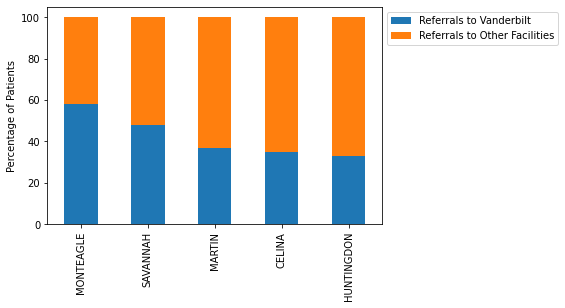

In [574]:
(out_of_community_city_comp
 .sort_values('vandy_percentage', ascending=False)
 .head(5)
 [['city_from','vandy_percentage','other_percentage']]
.rename(columns = {'vandy_percentage': 'Referrals to Vanderbilt',
                 'other_percentage':'Referrals to Other Facilities'})).plot(kind = 'bar', x = 'city_from',stacked = True)
plt.legend(loc='upper right', bbox_to_anchor = (1.54,1))
plt.xlabel('')
plt.ylabel('Percentage of Patients');

In [573]:
top_5below_avg = (out_of_community_city_comp
 .sort_values('vandy_percentage', ascending=False)
 .head(5)
 [['city_from','vandy_percentage','other_percentage']]
.rename(columns = {'vandy_percentage': 'Referrals to Vanderbilt',
                 'other_percentage':'Referrals to Other Facilities'}))

By percentage ['MONTEAGLE', 'SAVANNAH', 'MARTIN', 'CELINA', 'HUNTINGDON'] send the most patients out of community to vanderbilt, however, these places all have less than 10 doctors.

In [575]:
import plotly.graph_objs as go

In [584]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=top_5below_avg['Referrals to Vanderbilt'],
    x=top_5below_avg.city_from,
    name="Vanderbilt",
    marker=dict(
        color='rgba(0,128,0, 0.6)',
        line=dict(color='rgba(0,128,0, 0.5)', width=0.05)
    )))

fig.add_trace(go.Bar(
    y=top_5below_avg['Referrals to Other Facilities'],
    x=top_5below_avg.city_from,
    name="Other",
    marker=dict(
        color='rgba(0,0,255, 0.6)',
        line=dict(color='rgba(0,0,255, 0.5)', width=0.05)
    )
))

fig.update_layout(barmode = 'stack',
                  hovermode = 'x', 
                  yaxis = dict(title_text = 'Percentage of Patients'))
fig.show()

In [529]:
high_vandy_cities = out_of_community_city_comp[out_of_community_city_comp['total_d'] >= out_of_community_city_comp['total_d'].mean()].sort_values('vandy_percentage', ascending=False).head(5).city_from.to_list()

In [566]:
top_5_abv_avg = (out_of_community_city_comp[out_of_community_city_comp['total_d'] >=
                            out_of_community_city_comp['total_d'].mean()]
 .sort_values('vandy_percentage', ascending=False)
 .head(5)[['city_from','vandy_percentage','other_percentage']]
.rename(columns = {'vandy_percentage': 'Referrals to Vanderbilt',
                 'other_percentage':'Referrals to Other Facilities'}))

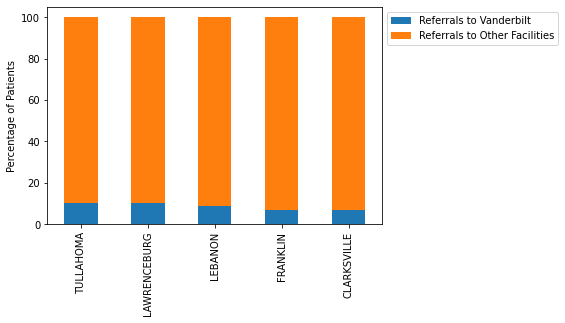

In [568]:
top_5_abv_avg.plot(kind = 'bar', x = 'city_from',stacked = True)
plt.legend(loc='upper right', bbox_to_anchor = (1.54,1))
plt.xlabel('')
plt.ylabel('Percentage of Patients')

When taking number of doctors into account, cities that refer to vanderbilt outside of their community most often by percentage are Tullahoma, Lawrenceburg, Lebanon, Franklin, and Clarksville.

In [585]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=top_5_abv_avg['Referrals to Vanderbilt'],
    x=top_5_abv_avg.city_from,
    name="Vanderbilt",
    marker=dict(
        color='rgba(0,128,0, 0.6)',
        line=dict(color='rgba(0,128,0, 0.5)', width=0.05)
    )))

fig.add_trace(go.Bar(
    y=top_5_abv_avg['Referrals to Other Facilities'],
    x=top_5_abv_avg.city_from,
    name="Other",
    marker=dict(
        color='rgba(0,0,255, 0.6)',
        line=dict(color='rgba(0,0,255, 0.5)', width=0.05)
    )
))

fig.update_layout(barmode = 'stack',
                  hovermode = 'x', 
                  yaxis = dict(title_text = 'Percentage of Patients'))
fig.show()

In [553]:
out_of_community_city_comp[out_of_community_city_comp['total_d'] >=
                            out_of_community_city_comp['total_d'].mean()].sort_values('vandy_percentage', ascending=False).head(5)

,city_from,state_from,sum_vandy_patients,num_vandy_doctors,sum_other_patients,num_other_doctors,total_p,total_d,vandy_percentage,other_percentage
82,TULLAHOMA,TN,3082,24,26650,56,29732,80,10.37,89.63
44,LAWRENCEBURG,TN,2238,24,19597,42,21835,66,10.25,89.75
45,LEBANON,TN,5421,29,56919,77,62340,106,8.70,91.30
24,FRANKLIN,TN,3703,26,48874,113,52577,139,7.04,92.96
10,CLARKSVILLE,TN,10216,55,136104,144,146320,199,6.98,93.02


In [547]:
out_of_community_city_comp[out_of_community_city_comp['city_from'] == 'NASHVILLE']

,city_from,state_from,sum_vandy_patients,num_vandy_doctors,sum_other_patients,num_other_doctors,total_p,total_d,vandy_percentage,other_percentage
67,NASHVILLE,TN,38556,238,1195896,1230,1234452,1468,3.12,96.88


In [586]:
top_5_abv_avg.to_csv('data/top_5_abv_avg')
top_5below_avg.to_csv('data/top_5below_avg')

In [591]:
out_of_community_city_comp.sort_values('total_p', ascending = False).head(6)

,city_from,state_from,sum_vandy_patients,num_vandy_doctors,sum_other_patients,num_other_doctors,total_p,total_d,vandy_percentage,other_percentage
67,NASHVILLE,TN,38556,238,1195896,1230,1234452,1468,3.12,96.88
65,MURFREESBORO,TN,14489,119,320923,424,335412,543,4.32,95.68
12,COLUMBIA,TN,14885,84,262675,218,277560,302,5.36,94.64
32,HENDERSONVILLE,TN,2485,23,220076,142,222561,165,1.12,98.88
33,HERMITAGE,TN,5643,43,192447,115,198090,158,2.85,97.15
25,GALLATIN,TN,3044,28,153177,100,156221,128,1.95,98.05
